In [1]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 3.6 MB/s 
     |████████████████████████████████| 9.9 MB 33.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_csv('average_gas_90days.csv')
df
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')
df.head()

,average_gas_fee,avgGas
timestamp,,
2022-09-12 10:00:00,10.585,92232.94520
2022-09-12 11:00:00,30.230,88143.43827
2022-09-12 12:00:00,33.410,82982.46142
2022-09-12 13:00:00,25.225,84544.98935
2022-09-12 14:00:00,52.245,89251.97150


In [5]:
df.rename(columns={'IPG2211A2N':'average_gas_fee'}, inplace=True) 
df.head()

,average_gas_fee,avgGas
timestamp,,
2022-09-12 10:00:00,10.585,92232.94520
2022-09-12 11:00:00,30.230,88143.43827
2022-09-12 12:00:00,33.410,82982.46142
2022-09-12 13:00:00,25.225,84544.98935
2022-09-12 14:00:00,52.245,89251.97150


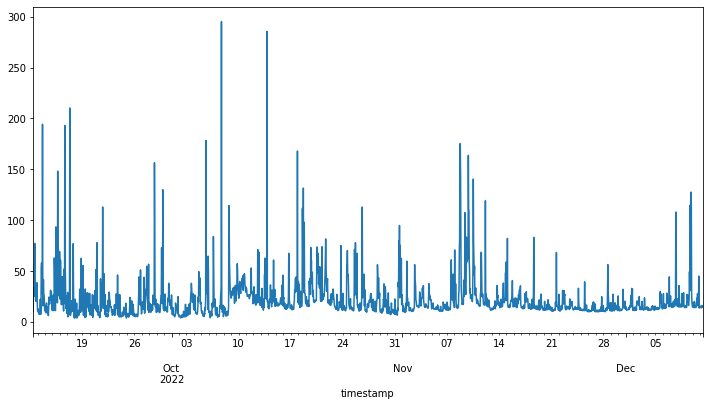

In [8]:
df['average_gas_fee'].plot(figsize=(12,6))

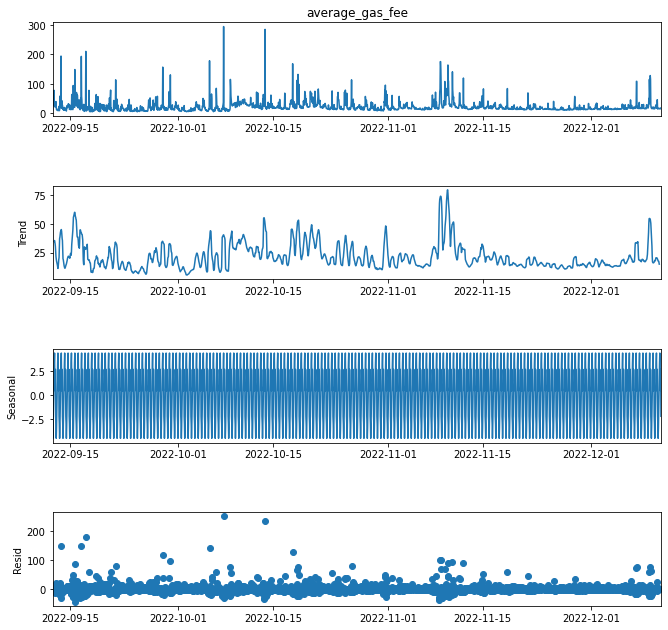

In [10]:
decomposition= sm.tsa.seasonal_decompose(df['average_gas_fee'], model='additive', period= 12 )

ax = decomposition.plot()
ax.set_size_inches(10,10)

plt.show()
# It is hard to say that our 90 days data has trend,  but it seems that our data has seasonality.

In [11]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

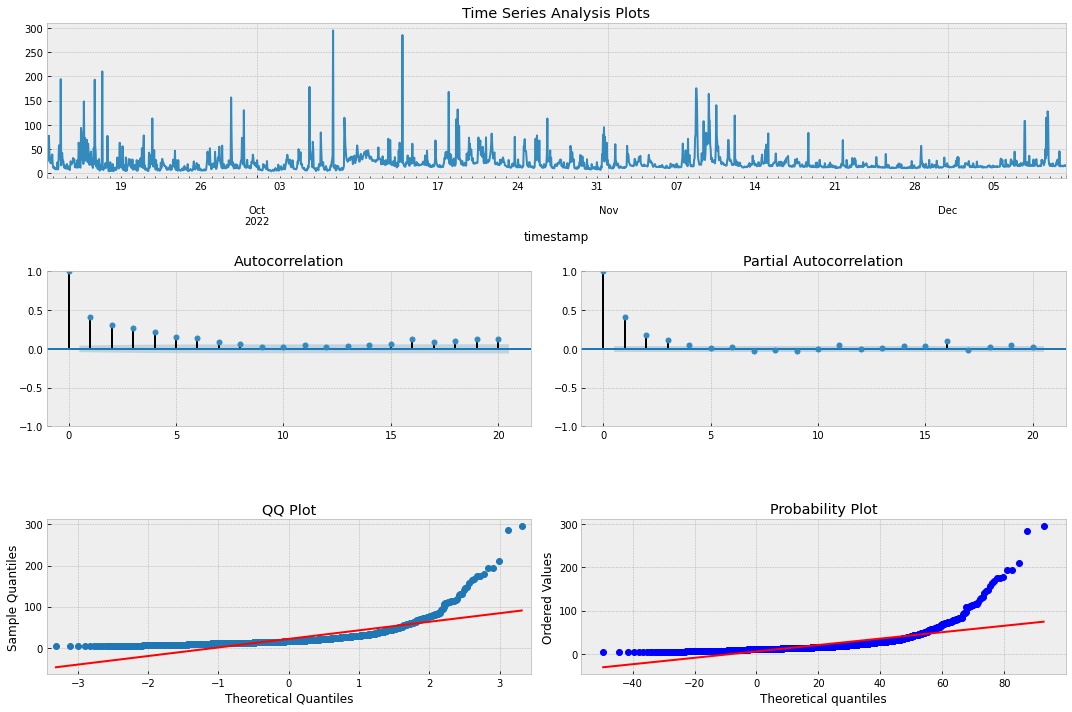

In [12]:
raw_data = tsplot(df['average_gas_fee'], lags=20)
# According to PACF, almost values are in range.

In [16]:
# Since there is no noticeable trend in 90 days data, just focus to keep the variation width with logarithm

df_log = np.log(df['average_gas_fee'])

#1st differencing with logarithm
diff_df_log = df_log.diff(periods=1).iloc[1:]

#2nd differencing with logarithm
diff_2_df_log = df_log.diff(periods=2).iloc[2:]

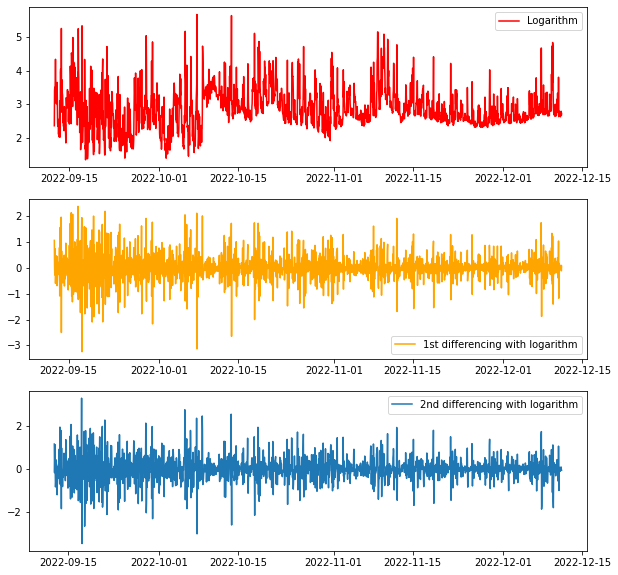

In [17]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_log, color='red')
ax1.legend(['Logarithm'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_log, color='orange')
ax2.legend(['1st differencing with logarithm'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_log)
ax3.legend(['2nd differencing with logarithm'])
# It seems with logarithm, the width of variation is not constant

In [18]:
# Using Box-cox transformation
df_boxcox = df.copy()

Optimal Lambda: -0.34789709575066674


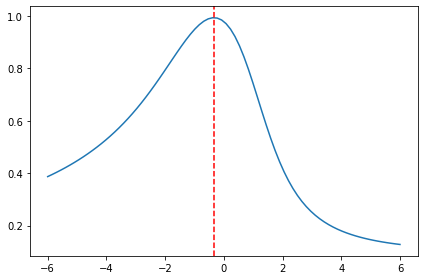

In [21]:
x, y = sp.stats.boxcox_normplot(df_boxcox.average_gas_fee, la=-6, lb=6)

y_transfer, l_opt = sp.stats.boxcox(df_boxcox.average_gas_fee)

print('Optimal Lambda:', l_opt)

plt.plot(x,y)
plt.axvline(x=l_opt, color='r', ls='--')
plt.tight_layout()
plt.show()

In [22]:
df_boxcox['average_gas_fee'] = boxcox(df['average_gas_fee'],lmbda=1.0748351764172541)

df_boxcox.head()

,average_gas_fee,avgGas
timestamp,,
2022-09-12 10:00:00,10.819464,92232.94520
2022-09-12 11:00:00,35.367828,88143.43827
2022-09-12 12:00:00,39.487564,82982.46142
2022-09-12 13:00:00,28.950656,84544.98935
2022-09-12 14:00:00,64.423756,89251.97150


In [23]:
#1st differencing with Box-Cox
diff_df_boxcox = df_boxcox.diff(periods=1).iloc[1:]

#2nd differencing with Box-Cox
diff_2_df_boxcox = df_boxcox.diff(periods=2).iloc[2:]

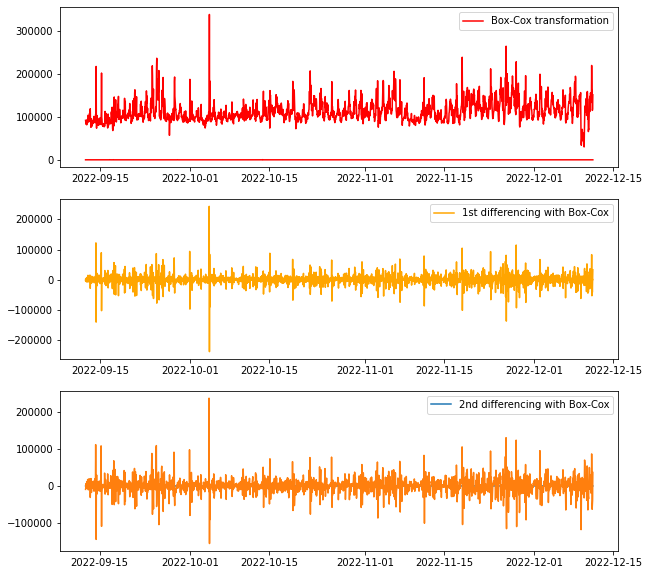

In [24]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_boxcox, color='red')
ax1.legend(['Box-Cox transformation'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_boxcox, color='orange')
ax2.legend(['1st differencing with Box-Cox'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_boxcox)
ax3.legend(['2nd differencing with Box-Cox'])

# It seems using box-cox transformation is more useful to keep the variation width than logarithm

In [29]:
# Average gas fee per time
df.groupby(df.index.hour)[['average_gas_fee']].mean()

,average_gas_fee
timestamp,
0,17.178306
1,16.989632
2,16.138377
3,16.748358
4,15.913900
5,14.499366
6,14.795867
7,14.939093
8,16.988091


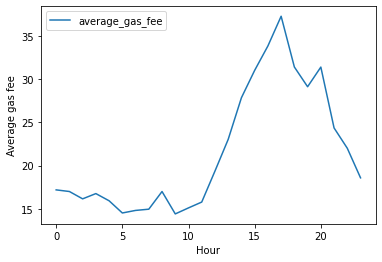

In [30]:
df.groupby(df.index.hour)[['average_gas_fee']].mean().plot()
plt.xlabel('Hour')
plt.ylabel('Average gas fee')
plt.show()
# Average gas fee is the lowest at 9:00AM and highest at 17:00PM in 90 days data

In [31]:
df.groupby(df.index.hour)[['average_gas_fee']].mean()[:12].mean() 
# Average gas fee at morning time (00:00 AM - 11:00 AM)

average_gas_fee    15.786363
dtype: float64

In [32]:
df.groupby(df.index.hour)[['average_gas_fee']].mean()[12:].mean() 
# Average gas fee at afternoon time (12:00 PM - 23:00 PM)
# It clearly seems that the gas fee is higer at the afternoon

average_gas_fee    27.453079
dtype: float64